# QOSF Mentorship Program - Task 1_variation2
## Prepare input state as superposition of only the states defined by given vector

As can be seen in the solution provided, the application of Grover's algorithm uses as input the equal superposition of all possible $2^{m}$ states. A further optimization to consider is to prepare the input state as the equal superposition of just the states defined by the input vector. In a real case, this should considerably improve the stability and reduce the noise in the system, since less states are considered. For the given input vector, this approach would consist of the state: 1/2(|0001> + |0101> + |0111> + |1010>) This approach is implemented below.


In [12]:
# Program Task 1_variation2
# Created by: Andres Diaz
# Date: 9/29/2021

# Load packages and standard Qiskit libraries
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

from qiskit.visualization import circuit_drawer

In [13]:
# Problem input and creation of dictionary
#     dictionary key   = input number in binary (four bits/qubits)
#     dictionary value = indices in binary (two bits/qubits)
input_list = [1,5,7,10]
input_dict = {}
for num in range(len(input_list)):
    element_bin = format(input_list[num], '#06b')
    integer_bin = format(num,'#04b')
    input_dict[element_bin[-4:]] = integer_bin[-2:]
print(input_dict)

{'0001': '00', '0101': '01', '0111': '10', '1010': '11'}


In [14]:
# These definitions are not necessary (or used), but will be useful in we desire to generalize the program
# to accept random values of size 2^n with m bits in length
n = 2   # n = number of addressing qbits
m = 4   # m = number of bits in length for each memory element

In [15]:
# Prepare input_state = 1/2(|0001> + |0101> + |0111> + |1010>). Resulting circuit will be input to class AmplificationProblem
# I did this manually but it can be automated
input_amplitudes = [0, 1/2, 0, 0, 0, 1/2, 0, 1/2, 0, 0, 1/2, 0, 0, 0, 0, 0]
State_preparation = QuantumCircuit(4)
State_preparation.initialize(input_amplitudes, [0,1,2,3])
State_preparation.draw()

┌──────────────────────────────────────────────────────┐
q_0: ┤0                                                     ├
     │                                                      │
q_1: ┤1                                                     ├
     │  Initialize(0,0.5,0,0,0,0.5,0,0.5,0,0,0.5,0,0,0,0,0) │
q_2: ┤2                                                     ├
     │                                                      │
q_3: ┤3                                                     ├
     └──────────────────────────────────────────────────────┘

In [16]:
# Configure backend
shots = 1024;
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=shots)

# Condition of two adjacents bits having different value is achieved 
# by AND operation between XOR of adjacent bits in binary representation 
expression = '(w ^ x) & (x ^ y) & (y ^ z)'

# Create new oracle
oracle = PhaseOracle(expression)
problem = AmplificationProblem(oracle) #,state_preparation = State_preparation) # objective_qubits = [1,5,7,10]) #
oracle.draw()

#Another option is to specify in the AmplificationProblem class the indices of the list of qubits that should be measured.
#This is done by setting the objective_qubits property.

q_0: ─■──■─────■─
      │  │     │ 
q_1: ─■──┼──■──■─
      │  │  │  │ 
q_2: ─┼──■──o──o─
      │  │  │    
q_3: ─o──o──■────

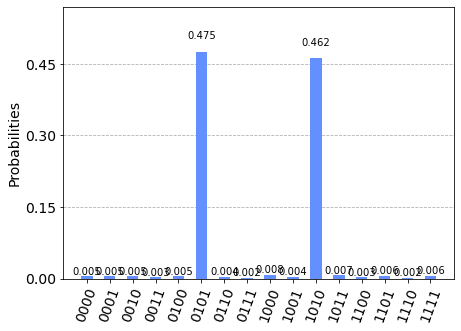

In [38]:
#Solve using Grover's algorithm
grover = Grover(iterations = 2, quantum_instance=quantum_instance)
result = grover.amplify(problem)
plot_histogram(result.circuit_results)

In [39]:
print(result.circuit_results[0])

{'1001': 4, '0001': 5, '1010': 473, '0101': 486, '1011': 7, '0011': 3, '1000': 8, '1111': 6, '0000': 5, '1101': 6, '1100': 3, '0110': 4, '0010': 5, '0100': 5, '0111': 2, '1110': 2}


In [40]:
# Determine probabilities corresponding to input elements
# and assign to output dictionary with keys = indices in binary
output_dict = {}
for input_key in input_dict.keys():
    print(input_key,input_dict[input_key],result.circuit_results[0][input_key]/shots)
    output_dict[input_dict[input_key]] = result.circuit_results[0][input_key]/shots

0001 00 0.0048828125
0101 01 0.474609375
0111 10 0.001953125
1010 11 0.4619140625


In [41]:
print(output_dict)

{'00': 0.0048828125, '01': 0.474609375, '10': 0.001953125, '11': 0.4619140625}


In [42]:
# It is given that the input contains at least two numbers with alternating bitstrings
# Hence, we look for the two highest probabilities. Only states are stored in output_list
max1 = max(output_dict, key = output_dict.get)
del output_dict[max1]
max2 = max(output_dict, key = output_dict.get)
output_list = [max1,max2]
print(output_list)

['01', '11']


In [43]:
# The output will be a quantum circuit which is the superposition of these two states
# Prepare list of complex amplitudes of [00,01,10,11] states
states = ['00','01','10','11']
amplitudes = [0,0,0,0]
for num in range(len(states)):
    if states[num] in output_list:
        amplitudes[num] = 1/np.sqrt(2)
    else:
        amplitudes[num] = 0    
    print(states[num], amplitudes[num])
    
# Declare and initialize output quantum circuit qc_out with the desired superposition of states
qc_out = QuantumCircuit(2)
qc_out.initialize(amplitudes, [0,1])
qc_out.draw()

00 0
01 0.7071067811865475
10 0
11 0.7071067811865475


┌──────────────────────────────────┐
q_0: ┤0                                 ├
     │  Initialize(0,0.70711,0,0.70711) │
q_1: ┤1                                 ├
     └──────────────────────────────────┘